In [5]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import ResNet50V2
from keras import layers
from tensorflow import data as tf_data
import os
import random

In [6]:
import zipfile

In [7]:
import shutil

In [8]:
zip_file_path = "/content/CSAFE_Handwriting_Images.zip"
extract_to_path = "/content/Data"

In [9]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [10]:
source_dir = "/content/Data"
dest_dir = source_dir

os.makedirs(dest_dir, exist_ok=True)

for filename in os.listdir(source_dir):
    if filename.endswith(".png"):
        # Extract writer ID from filename, assumes format "wxxxx_syy_pzzz_rqq"
        writer_id = filename.split("_")[0]  # 'wxxxx'

        writer_folder = os.path.join(dest_dir, writer_id)
        os.makedirs(writer_folder, exist_ok=True)

        src_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(writer_folder, filename)

        shutil.move(src_path, dest_path)

In [11]:
os.listdir(f"{dest_dir}/w0001") #get list of files in directory

['w0001_s03_pWOZ_r03.png',
 'w0001_s01_pLND_r01.png',
 'w0001_s01_pLND_r03.png',
 'w0001_s03_pPHR_r03.png',
 'w0001_s03_pLND_r01.png',
 'w0001_s01_pPHR_r03.png',
 'w0001_s03_pLND_r03.png',
 'w0001_s01_pWOZ_r03.png',
 'w0001_s02_pPHR_r01.png',
 'w0001_s03_pPHR_r02.png',
 'w0001_s03_pWOZ_r02.png',
 'w0001_s02_pWOZ_r02.png',
 'w0001_s02_pWOZ_r01.png',
 'w0001_s03_pPHR_r01.png',
 'w0001_s01_pWOZ_r02.png',
 'w0001_s01_pWOZ_r01.png',
 'w0001_s02_pWOZ_r03.png',
 'w0001_s01_pPHR_r02.png',
 'w0001_s01_pPHR_r01.png',
 'w0001_s02_pPHR_r03.png',
 'w0001_s03_pLND_r02.png',
 'w0001_s02_pLND_r03.png',
 'w0001_s02_pLND_r02.png',
 'w0001_s02_pPHR_r02.png',
 'w0001_s02_pLND_r01.png',
 'w0001_s03_pWOZ_r01.png',
 'w0001_s01_pLND_r02.png']

In [12]:
w_ids = os.listdir("/content/Data")
w_ids.sort()
w_ids[:5]

['CSAFE_Handwriting_Info.csv', 'w0001', 'w0002', 'w0003', 'w0004']

In [13]:
w_ids.pop(0)
w_ids[:5]

['w0001', 'w0002', 'w0003', 'w0004', 'w0005']

In [14]:
len(w_ids)

90

In [15]:
round(27*0.8)

22

In [16]:
source_dir

'/content/Data'

In [17]:
for writer in w_ids:
    writer_path = f"{source_dir}/{writer}"

    writer_images = os.listdir(writer_path) #list of all images for writer

    #shuffle images
    random.shuffle(writer_images)

    train_set = writer_images[:22] #80/20 split --> 22/5
    val_set = writer_images[22:]

    #create sub directories in writer folders
    train_folder = os.path.join(source_dir, "train")
    val_folder = os.path.join(source_dir, "val")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    for image in train_set: #loop over every image for training in og place
        path = os.path.join(writer_path,image) #image og path
        destination = os.path.join(train_folder,writer)
        os.makedirs(destination, exist_ok=True)

        shutil.move(path, destination) #move to writer directory in train folder

    for image in val_set:
        path = os.path.join(writer_path,image)
        destination = os.path.join(val_folder,writer)
        os.makedirs(destination, exist_ok=True)

        shutil.move(path, destination)


In [18]:
w_ids[0]

'w0001'

In [19]:
for writer in w_ids: #delete old writer folders
    try:
        os.rmdir(f"{source_dir}/{writer}")
    except:
        pass

In [20]:
len(os.listdir(f"{source_dir}/train"))

90

In [21]:
IMAGE_SIZE = (384,384)
BATCH_SIZE = 18

    Tried both 512,512 and 448,448 (to preserve details); runtime crashed

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Data/train",
    labels='inferred',
    color_mode='rgb',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    #validation_split=0.001,
    #subset= "training",
    #seed=42
    )


val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Data/val",
    labels='inferred',
    color_mode='rgb',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    #validation_split=0.999,
    #subset= "validation",
    #seed=42
    )

Found 1980 files belonging to 90 classes.
Found 450 files belonging to 90 classes.


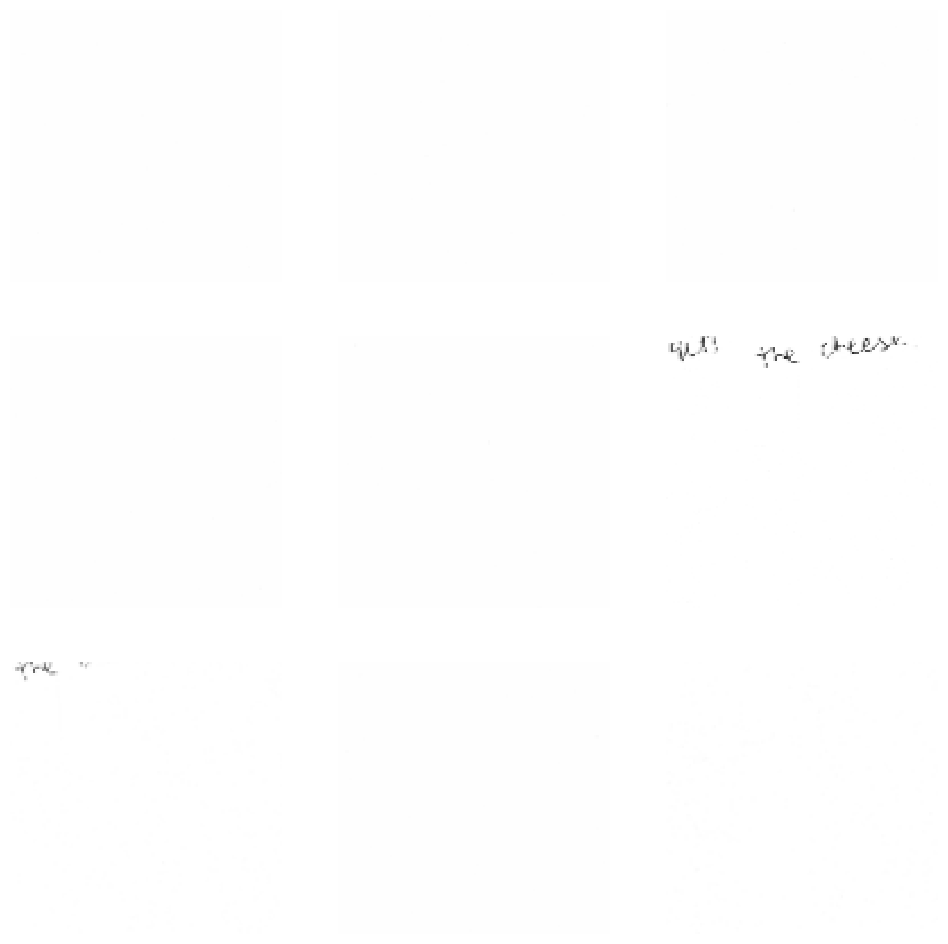

In [23]:
data_augmentation_layers = [
    layers.RandomRotation(0.02),
    layers.RandomCrop(120,120),
    #layers.RandomZoom(height_factor=(0.2, 0.5), width_factor=(0.2, 0.5)),
    layers.RandomContrast((0.2,0.5)),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images
plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"),cmap="gray",interpolation="nearest")
        plt.axis("off")

    Concerns about cropping in too much whitespace ^^

### Modelling

In [24]:
from keras.applications import ResNet50V2

In [25]:
INPUT_SHAPE = IMAGE_SIZE + (3,)
INPUT_SHAPE

(384, 384, 3)

In [26]:
base_model = ResNet50V2(include_top = False,
                        classifier_activation="softmax",
                        weights = "imagenet",
                        input_shape=(IMAGE_SIZE + (3,))
                        )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = base_model

    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.resnet.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)

    units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="baseline")


model = make_transfer_model(input_shape=INPUT_SHAPE, num_classes=90)

In [28]:
from tensorflow import data as tf_data

In [29]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE) #train_ds = train_ds.cache().prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE) #val_ds = val_ds.cache().prefetch(tf_data.AUTOTUNE)

In [ ]:
epochs = 8

callbacks = [keras.callbacks.ModelCheckpoint("save_at_epoch{epoch}.keras"),]

model.compile(
    optimizer= "adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

history = model.fit(
    train_ds,
    epochs= epochs,
    callbacks= callbacks,
    validation_data= val_ds,)


In [ ]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()
plt.show()

In [10]:
import matplotlib.pyplot as plt

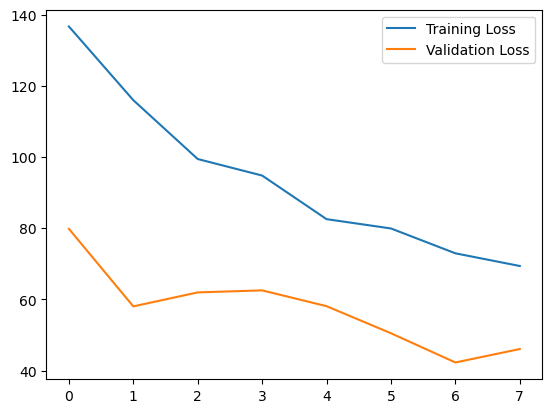

In [11]:
plt.plot(range(8),
         [136.7275,116.0169,99.4707,94.8276,82.5701,79.9546,72.9690,69.4060],
         label="Training Loss")

plt.plot(range(8),
         [79.8570,58.0530,61.9865,62.5520,58.1141,50.5001,42.2873,46.0645],
         label="Validation Loss")
plt.legend()
plt.show()

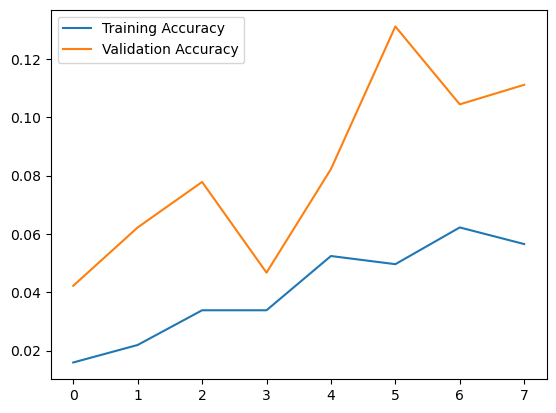

In [14]:
plt.plot(range(8),
         [0.0159,0.0219,0.0338,0.0338,0.0524,0.0496,0.0622,0.0565],
         label="Training Accuracy")

plt.plot(range(8),
         [0.0422,0.0622, 0.0778,0.0467,0.0822,0.1311,0.1044, 0.1111],
         label="Validation Accuracy")
plt.legend()
plt.show()

    Was able to save results from initial training (8 epochs) ^^